In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

url = 'https://raw.githubusercontent.com/akay6483/mmml-ecommerce/refs/heads/main/dataset/online_shoppers_intention.csv'
df = pd.read_csv(url).drop_duplicates()

X = df.drop('Revenue', axis=1)
y = df['Revenue']

for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = pd.factorize(X[col])[0]
y = LabelEncoder().fit_transform(y)

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Data Processed. Features: {X.shape[1]}, Samples: {X.shape[0]}")

Data Processed. Features: 17, Samples: 12205


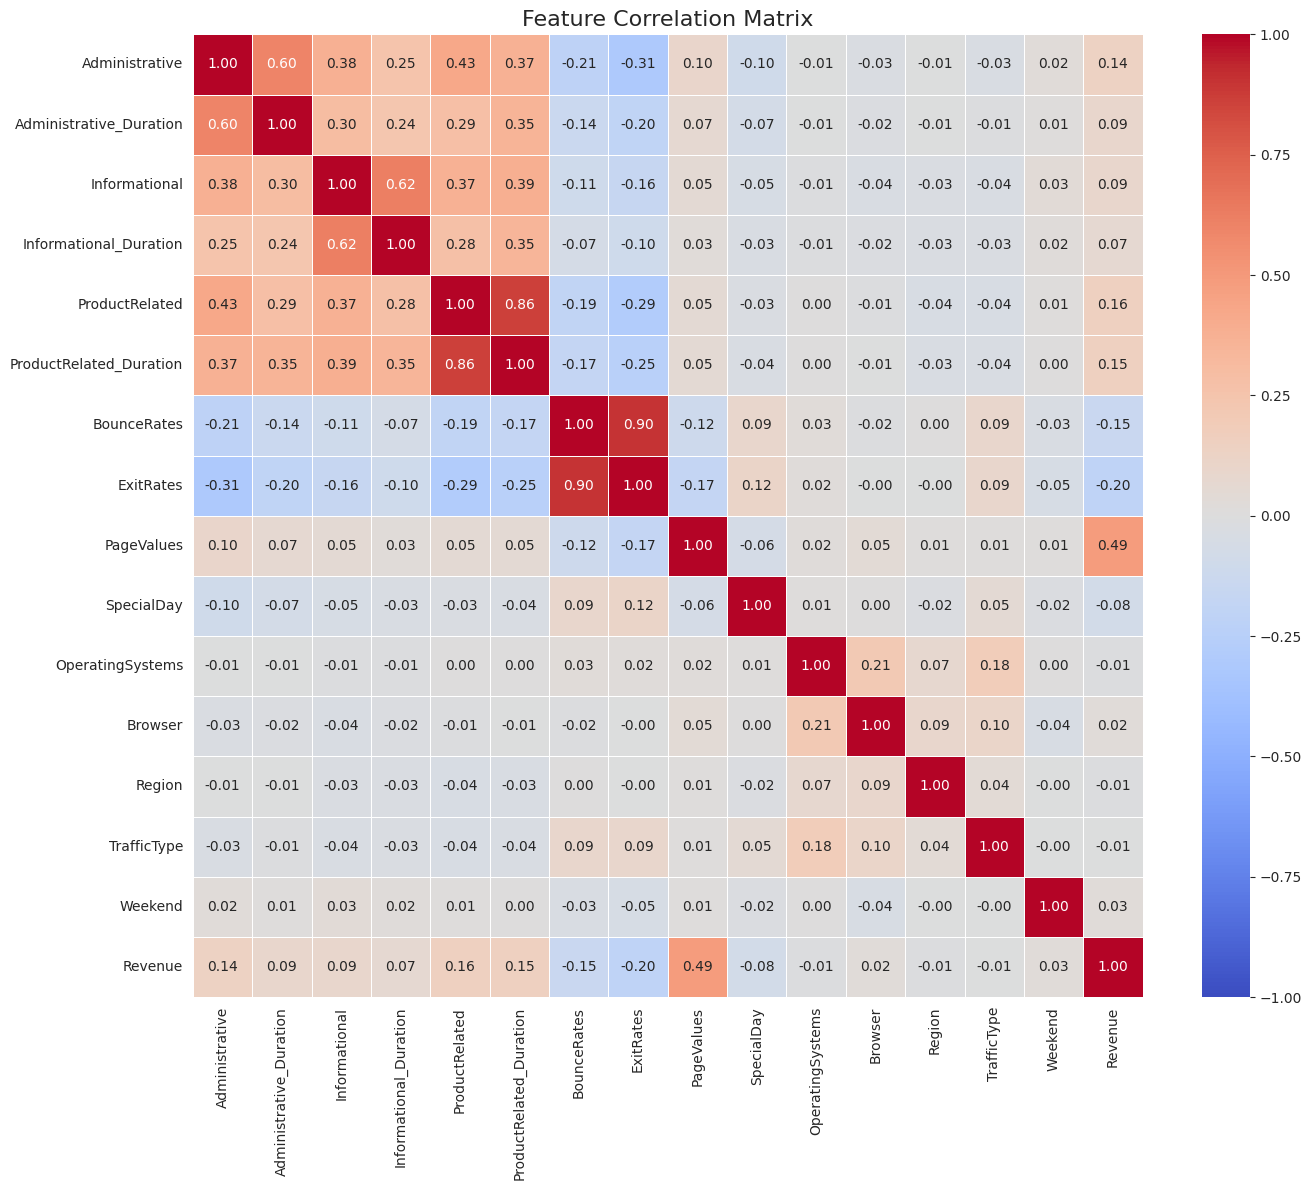

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute Correlation Matrix
# numeric_only=True ensures we only correlate numerical columns
corr_matrix = df.corr(numeric_only=True)

# 2. Plot Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix,
            annot=True,       # Show the numbers
            fmt=".2f",        # Format to 2 decimal places
            cmap='coolwarm',  # Red = Positive, Blue = Negative
            vmin=-1, vmax=1,  # Set scale from -1 to +1
            linewidths=0.5)   # Add white lines between squares

plt.title("Feature Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

PCA
Number of components for 95% variance: 14


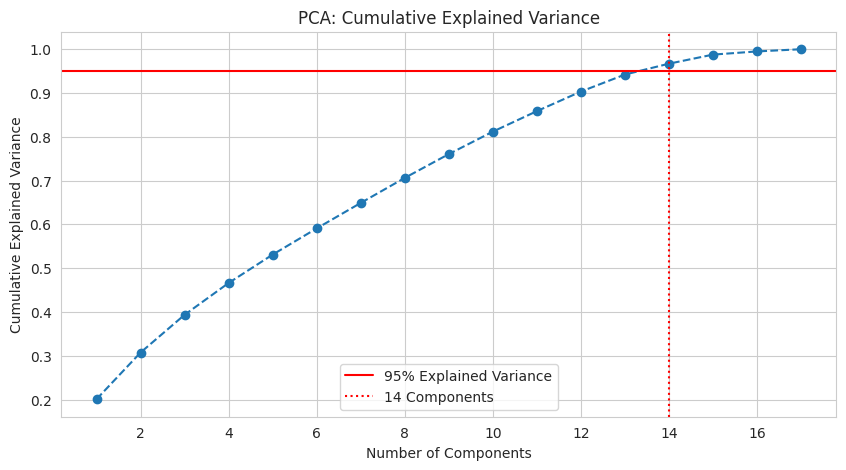

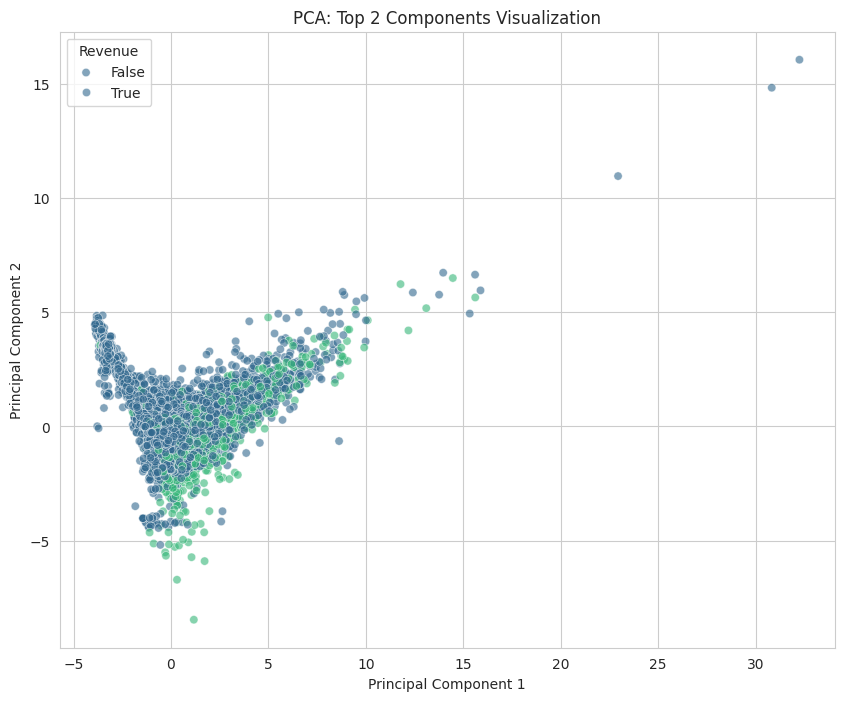

In [75]:
print("PCA")

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components for 95% variance: {n_components_95}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.axvline(x=n_components_95, color='r', linestyle=':', label=f'{n_components_95} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=y, palette='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Top 2 Components Visualization')
plt.legend(title='Revenue', labels=['False', 'True'])
plt.show()

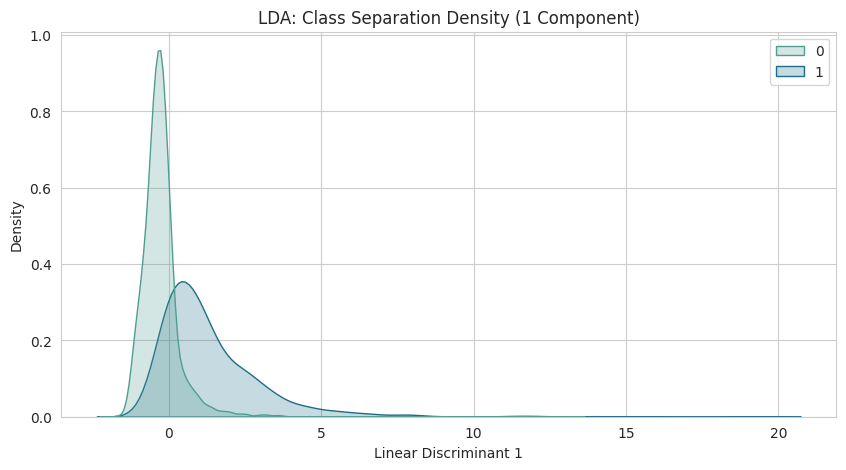

Running Feature Selection...

=== Final Results ===
LDA Accuracy:                         0.8820
Logistic Regression (All 17 Features): 0.8880
Logistic Regression (Top 5 Features):  0.8872
Top 5 Features Selected: ['ExitRates', 'PageValues', 'Browser', 'VisitorType', 'Weekend']


In [76]:
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)
y_pred_lda = lda.predict(X_test)

plt.figure(figsize=(10, 5))
sns.kdeplot(x=X_lda.flatten(), hue=y_train, fill=True, palette='crest', common_norm=False)
plt.title('LDA: Class Separation Density (1 Component)')
plt.xlabel('Linear Discriminant 1')
plt.show()

print("Running Feature Selection...")
clf = LogisticRegression(max_iter=1000, random_state=42)
sfs = SequentialFeatureSelector(clf, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)

selected_feats = X.columns[sfs.get_support()].tolist()

clf.fit(sfs.transform(X_train), y_train)
acc_sfs = accuracy_score(y_test, clf.predict(sfs.transform(X_test)))

clf.fit(X_train, y_train)
acc_all = accuracy_score(y_test, clf.predict(X_test))

print("\n=== Final Results ===")
print(f"LDA Accuracy:                         {accuracy_score(y_test, y_pred_lda):.4f}")
print(f"Logistic Regression (All 17 Features): {acc_all:.4f}")
print(f"Logistic Regression (Top 5 Features):  {acc_sfs:.4f}")
print(f"Top 5 Features Selected: {selected_feats}")

In [77]:
print("Running Sequential Feature Selection (this may take a moment)...")

model_lr = LogisticRegression(max_iter=1000, random_state=42)

sfs = SequentialFeatureSelector(model_lr, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)

selected_indices = sfs.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()
print(f"Top 5 Selected Features: {selected_features}")

X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
model_lr.fit(X_train_sfs, y_train)
acc_sfs = accuracy_score(y_test, model_lr.predict(X_test_sfs))

model_lr.fit(X_train, y_train)
acc_all = accuracy_score(y_test, model_lr.predict(X_test))

print(f"Accuracy (All 17 Features): {acc_all:.4f}")
print(f"Accuracy (Top 5 Features): {acc_sfs:.4f}")

Running Sequential Feature Selection (this may take a moment)...
Top 5 Selected Features: ['ExitRates', 'PageValues', 'Browser', 'VisitorType', 'Weekend']
Accuracy (All 17 Features): 0.8880
Accuracy (Top 5 Features): 0.8872


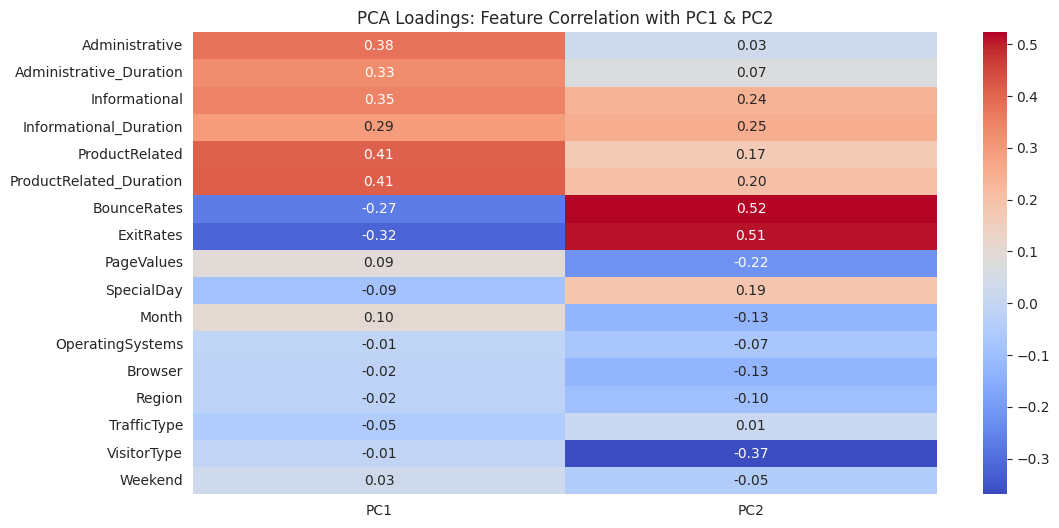

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report, confusion_matrix


plt.figure(figsize=(12, 6))
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('PCA Loadings: Feature Correlation with PC1 & PC2')
plt.show()


RESULTS: Baseline (All Features)
              precision    recall  f1-score   support

  No Revenue       0.90      0.98      0.94      3116
     Revenue       0.75      0.38      0.50       546

    accuracy                           0.89      3662
   macro avg       0.82      0.68      0.72      3662
weighted avg       0.88      0.89      0.87      3662



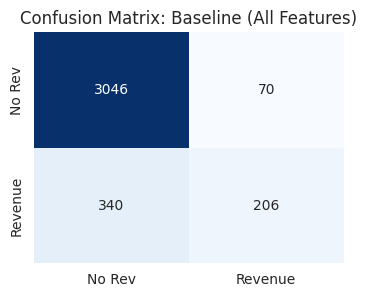


RESULTS: PCA (10 Components)
              precision    recall  f1-score   support

  No Revenue       0.90      0.98      0.94      3116
     Revenue       0.74      0.37      0.50       546

    accuracy                           0.89      3662
   macro avg       0.82      0.68      0.72      3662
weighted avg       0.88      0.89      0.87      3662



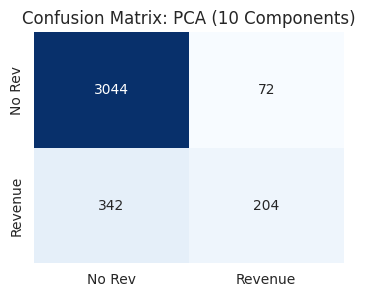


RESULTS: LDA (1 Component)
              precision    recall  f1-score   support

  No Revenue       0.90      0.97      0.94      3116
     Revenue       0.72      0.38      0.50       546

    accuracy                           0.89      3662
   macro avg       0.81      0.68      0.72      3662
weighted avg       0.87      0.89      0.87      3662



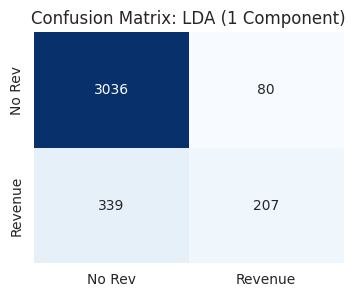

Running SFS (selecting top 5 features)...
Selected Features: ['ExitRates', 'PageValues', 'Browser', 'VisitorType', 'Weekend']

RESULTS: SFS (Top 5 Features)
              precision    recall  f1-score   support

  No Revenue       0.90      0.98      0.94      3116
     Revenue       0.75      0.36      0.49       546

    accuracy                           0.89      3662
   macro avg       0.83      0.67      0.71      3662
weighted avg       0.88      0.89      0.87      3662



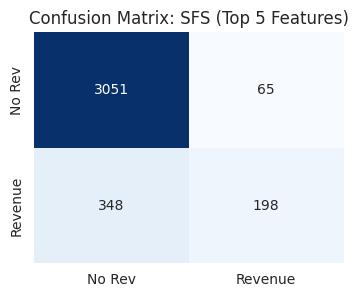

In [79]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(X_tr, y_tr, X_te, y_te, name, results_list):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)

    print(f"\n{'='*40}")
    print(f"RESULTS: {name}")
    print(f"{'='*40}")
    print(classification_report(y_te, y_pred, target_names=['No Revenue', 'Revenue']))

    rec = recall_score(y_te, y_pred, pos_label=1)
    prec = precision_score(y_te, y_pred, pos_label=1, zero_division=0)
    results_list.append({'Technique': name, 'Recall (Revenue)': rec, 'Precision': prec})

    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Rev', 'Revenue'],
                yticklabels=['No Rev', 'Revenue'])
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

comparison_results = []

evaluate_model(X_train, y_train, X_test, y_test, "Baseline (All Features)", comparison_results)

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
evaluate_model(X_train_pca, y_train, X_test_pca, y_test, "PCA (10 Components)", comparison_results)

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
evaluate_model(X_train_lda, y_train, X_test_lda, y_test, "LDA (1 Component)", comparison_results)

print("Running SFS (selecting top 5 features)...")
lr_sfs = LogisticRegression(max_iter=1000, random_state=42)
sfs = SequentialFeatureSelector(lr_sfs, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)

X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

selected_cols = X.columns[sfs.get_support()]
print(f"Selected Features: {list(selected_cols)}")

evaluate_model(X_train_sfs, y_train, X_test_sfs, y_test, "SFS (Top 5 Features)", comparison_results)

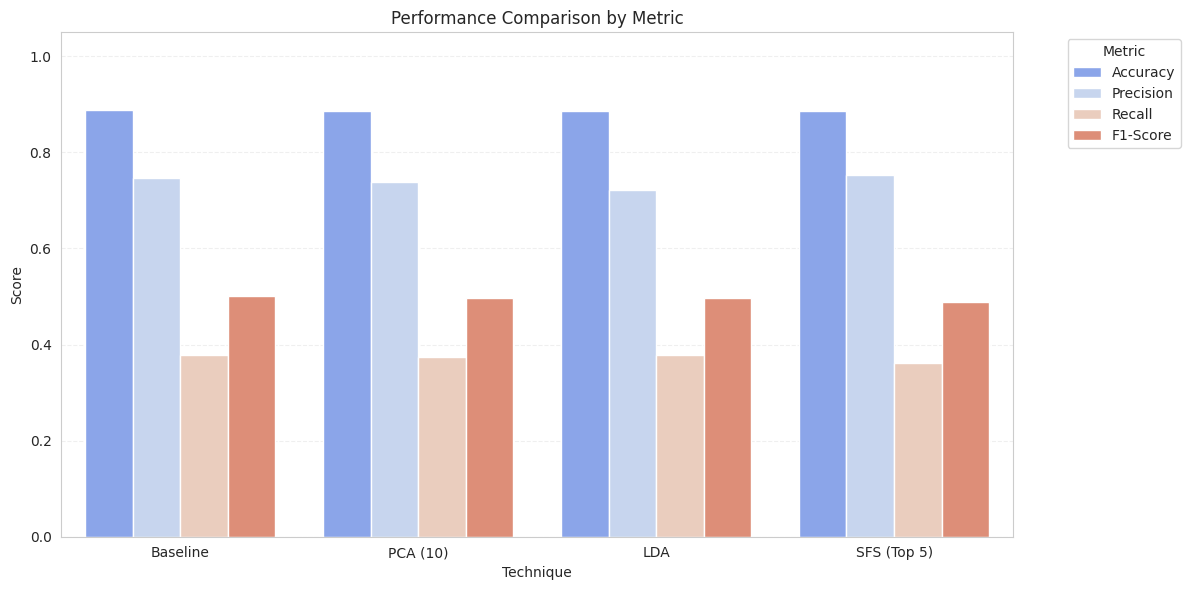

     Technique  Accuracy  Precision    Recall  F1-Score
0     Baseline  0.888039   0.746377  0.377289  0.501217
1     PCA (10)  0.886947   0.739130  0.373626  0.496350
2          LDA  0.885582   0.721254  0.379121  0.496999
3  SFS (Top 5)  0.887220   0.752852  0.362637  0.489493


In [80]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = []

def run_and_log(X_tr, X_te, name):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)

    results.append({
        'Technique': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        'Recall': recall_score(y_test, y_pred, pos_label=1),
        'F1-Score': f1_score(y_test, y_pred, pos_label=1)
    })

# Corrected to use X_train and X_test which are already scaled
run_and_log(X_train, X_test, "Baseline")

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
run_and_log(X_train_pca, X_test_pca, "PCA (10)")

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
run_and_log(X_train_lda, X_test_lda, "LDA")

# Make sure X_train_sfs and X_test_sfs are defined from a previous cell or within this cell
# Assuming they are defined from the previous SFS cell
run_and_log(X_train_sfs, X_test_sfs, "SFS (Top 5)")

df_results = pd.DataFrame(results)

df_melted = df_results.melt(id_vars="Technique", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Technique", y="Score", hue="Metric", palette="coolwarm")

plt.title("Performance Comparison by Metric")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
print(df_results)
